In [4]:
import pandas as pd
import numpy as np

from pyincore import IncoreClient
from pyincore.analyses.socialvulnerability import SocialVulnerability
from pyincore_data.censusutil import CensusUtil
from pyincore import Dataset

In [5]:
client = IncoreClient()

Connection successful to IN-CORE services. pyIncore version detected: 1.14.0


In [6]:
state = "florida"
county = "lee"
year = 2022

In [7]:
# get fips code to use fetch census data
fips = CensusUtil.get_fips_by_state_county(state=state, county=county)
state_code = fips[:2]
county_code = fips[2:]
fips

'12071'

In [8]:
def demographic_factors(state_number, county_number, year, geo_type="tract:*"):

    api_json_1, df_1, ds_1 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                              data_source="acs/acs5",
                                                              columns="GEO_ID,B03002_001E,B03002_003E",
                                                              geo_type=geo_type)
    df_1["factor_white_nonHispanic"] = df_1[["B03002_001E","B03002_003E"]].astype(int).apply(lambda row: row["B03002_003E"]/row["B03002_001E"] if row["B03002_001E"] != 0 else 999, axis = 1)

    api_json_2, df_2, ds_2 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                  data_source="acs/acs5",
                                                  columns="B25003_001E,B25003_002E",
                                                  geo_type=geo_type)
    df_2["factor_owner_occupied"] = df_2.astype(int).apply(lambda row: row["B25003_002E"]/row["B25003_001E"] if row["B25003_001E"] != 0 else 999, axis = 1)
    
    api_json_3, df_3, ds_3 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B17021_001E,B17021_002E",
                                         geo_type=geo_type)
    df_3["factor_earning_higher_than_national_poverty_rate"] = df_3.astype(int).apply(lambda row: 1-row["B17021_002E"]/row["B17021_001E"] if row["B17021_001E"] != 0 else 999, axis = 1)
    
    api_json_4, df_4, ds_4 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5", 
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=geo_type)
    df_4["factor_over_25_with_high_school_diploma_or_higher"] = df_4.astype(int).apply(lambda row: (row["B15003_017E"] 
                                                                                                    + row["B15003_018E"] 
                                                                                                    + row["B15003_019E"] 
                                                                                                    + row["B15003_020E"] 
                                                                                                    + row["B15003_021E"] 
                                                                                                    + row["B15003_022E"] 
                                                                                                    + row["B15003_023E"] 
                                                                                                    + row["B15003_024E"] 
                                                                                                    + row["B15003_025E"])/row["B15003_001E"] if row["B15003_001E"] != 0 else 999, axis = 1)

    if geo_type == 'tract:*':
        api_json_5, df_5, ds_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                             geo_type=geo_type)
        df_5["factor_without_disability_age_18_to_65"] = df_5.astype(int).apply(lambda row: (row["B18101_011E"] + row["B18101_014E"] + row["B18101_030E"] + row["B18101_033E"])/row["B18101_001E"] if row["B18101_001E"] != 0 else 999, axis = 1)
    
    elif geo_type == 'block%20group:*':
        api_json_5, df_5, ds_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B01003_001E,C21007_006E,C21007_009E,C21007_013E,C21007_016E",
                                             geo_type=geo_type)

        df_5['factor_without_disability_age_18_to_65'] = df_5.astype(int).apply(lambda row: (row['C21007_006E']+
                                                                                 row['C21007_006E']+
                                                                                 row['C21007_009E']+
                                                                                 row['C21007_013E'])
                                                                                /row['C21007_016E'] if row["C21007_016E"] != 0 else 999, axis = 1)

    df_t = pd.concat([df_1[["GEO_ID","factor_white_nonHispanic"]],
                      df_2["factor_owner_occupied"],
                      df_3["factor_earning_higher_than_national_poverty_rate"], 
                      df_4["factor_over_25_with_high_school_diploma_or_higher"],
                      df_5["factor_without_disability_age_18_to_65"]], 
                     axis=1, join='inner')
    
    # extract FIPS from geo id
    df_t["FIPS"] = df_t.apply(lambda row: row["GEO_ID"].split("US")[1], axis = 1)
        
    return df_t

In [9]:
def national_ave_values (year, data_source="acs/acs5"):
    api_json_1, nav1, ds_1 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B03002_001E,B03002_003E",geo_type=None)
    nav1 = nav1.astype(int)
    nav1_avg ={"feature": "NAV-1: White, nonHispanic", 
                "average": nav1['B03002_003E'].sum()/ nav1['B03002_001E'].sum()}

    api_json_2, nav2, ds_2 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B25003_001E,B25003_002E",geo_type=None)
    nav2 = nav2.astype(int)
    nav2_avg = {"feature": "NAV-2: Home Owners", 
                "average": nav2['B25003_002E'].sum()/nav2['B25003_001E'].sum()}

    api_json_3, nav3, ds_3 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B17021_001E,B17021_002E",geo_type=None)
    nav3 = nav3.astype(int)
    nav3_avg = {"feature": "NAV-3: earning higher than national poverty rate", 
                "average": 1-nav3['B17021_002E'].sum()/nav3['B17021_001E'].sum()}

    api_json_4, nav4, ds_4 = CensusUtil.get_census_data(state="*", 
                                         county=None, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=None)
    nav4 = nav4.astype(int)
    nav4['temp'] = nav4.apply(lambda row: row['B15003_017E']+row['B15003_018E']+row['B15003_019E']+
                              row['B15003_020E']+row['B15003_021E']+row['B15003_022E']+row['B15003_023E']+
                              row['B15003_024E']+row['B15003_025E'], axis = 1)
    nav4_avg = {"feature": 'NAV-4: over 25 with high school diploma or higher', 
                "average": nav4['temp'].sum()/nav4['B15003_001E'].sum()}

    api_json_5, nav5, ds_5 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                         geo_type=None)
    nav5 = nav5.astype(int)
    nav5['temp'] = nav5.apply(lambda row: row['B18101_011E']+row['B18101_014E']+row['B18101_030E']+row['B18101_033E'], axis = 1)
    nav5_avg = {"feature": 'NAV-5: without disability age 18 to 65', 
                "average": nav5["temp"].sum()/nav5["B18101_001E"].sum()}
    
    navs = [nav1_avg, nav2_avg, nav3_avg, nav4_avg, nav5_avg]
    
    return navs

In [10]:
navs = national_ave_values(year=2022)
national_vulnerability_feature_averages = Dataset.from_csv_data(navs, name="national_vulnerability_feature_averages.csv",
                                                                 data_type="incore:socialVulnerabilityFeatureAverages")

csv saved as api_20240526-164437.csv
csv saved as api_20240526-164438.csv
csv saved as api_20240526-164440.csv
csv saved as api_20240526-164442.csv
csv saved as api_20240526-164443.csv


In [11]:
geo_type = "tract:*"
social_vunlnerability_dem_factors_df = demographic_factors(state_code, county_code, year=2022, geo_type=geo_type)
social_vunlnerability_dem_factors = Dataset.from_dataframe(social_vunlnerability_dem_factors_df, 
                                                           name="social_vunlnerability_dem_factors",
                                                           data_type="incore:socialVulnerabilityDemFactors")

csv saved as api_20240526-164446.csv
csv saved as api_20240526-164447.csv
csv saved as api_20240526-164449.csv
csv saved as api_20240526-164450.csv
csv saved as api_20240526-164452.csv


In [12]:
# Configure pyincore access and the analysis with the information above

client = IncoreClient()
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "social_vulnerabilty")
social_vulnerability.set_input_dataset("national_vulnerability_feature_averages", national_vulnerability_feature_averages)
social_vulnerability.set_input_dataset("social_vulnerability_demographic_factors", social_vunlnerability_dem_factors)

Enter username:  zacbaker
Enter password:  ········


Connection successful to IN-CORE services. pyIncore version detected: 1.14.0


True

In [13]:
# Run social vulnerability damage analysis
result = social_vulnerability.run_analysis()

In [14]:
# Retrieve result dataset
result = social_vulnerability.get_output_dataset("sv_result")

# Convert dataset to Pandas DataFrame
sv_df = result.get_dataframe_from_csv()
sv_df.head()

,GEO_ID,factor_white_nonHispanic,factor_owner_occupied,factor_earning_higher_than_national_poverty_rate,factor_over_25_with_high_school_diploma_or_higher,factor_without_disability_age_18_to_65,FIPS,R1,R2,R3,R4,R5,SVS,zone
0,1400000US12071000303,0.304398,0.622924,0.794084,0.671244,0.546007,12071000303,0.522188,0.960599,0.910952,0.753846,0.996831,0.828883,Medium to High Vulnerable (zone4)
1,1400000US12071000304,0.721519,0.324147,0.931284,0.923497,0.677517,12071000304,1.237750,0.499861,1.068345,1.037141,1.236924,1.016004,Medium Vulnerable (zone3)
2,1400000US12071000305,0.080253,0.329201,0.800422,0.691824,0.591341,12071000305,0.137673,0.507655,0.918224,0.776958,1.079596,0.684021,High Vulnerable (zone5)
3,1400000US12071000306,0.203542,0.294118,0.759348,0.573745,0.651392,12071000306,0.349172,0.453553,0.871104,0.644349,1.189229,0.701481,High Vulnerable (zone5)
4,1400000US12071000401,0.344257,0.651111,0.899662,0.656484,0.588814,12071000401,0.590565,1.004066,1.032069,0.737270,1.074981,0.887790,Medium to High Vulnerable (zone4)


In [15]:
# plotting the social vulnerability data in lee county

In [16]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import contextily as ctx 
import geopandas as gpd 
!pip install seaborn
import seaborn as sns
import os 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [31]:
# load openfema owners data
owner_data = gpd.read_file(r"../data/HousingAssistanceOwners.csv")
owner_data.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,averageFemaInspectedDamage,totalInspected,totalDamage,noFemaInspectedDamage,...,totalApprovedIhpAmount,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id,geometry
0,1439,TX,Aransas (County),ARANSAS PASS,78335,4,1345.01,3,5380.02,0,...,5915.91,3573.02,970,1372.89,3,0,0,0,24148449-87c6-4f58-8d14-e469c3f0581a,None
1,1439,TX,Aransas (County),ARANSAS PASS,78336,68,3082.82,63,209632.06,4,...,180717.57,131097.36,23946,25674.21,27,26,1,0,03688be7-62df-43e2-b2b3-0eefc8516644,None
2,1439,TX,Aransas (County),FULTON,78358,20,4722.34,18,94446.72,0,...,94240.88,58754.7,6784,28702.18,3,11,3,0,fa08ef35-8563-49bb-bb74-2fe8d64f4d77,None
3,1439,TX,Aransas (County),FULTON,78381,1,2578.3,1,2578.3,0,...,3304.3,1407.96,726,1170.34,1,0,0,0,fc5e65b1-522d-48e7-b3e2-69eb560caf00,None
4,1439,TX,Aransas (County),ROCKPORT,78331,1,0,0,0,0,...,0,0,0,0,0,0,0,0,37a8634d-3c69-44a3-8414-c281e22ff561,None


In [33]:
# load shape file for Lee County, Florida which has the intersection of zip codes and census tracts

joint_tracts_zip = gpd.read_file(r"../lee_county_zip_tract_intersection.shp")
joint_tracts_zip = joint_tracts_zip.to_crs("EPSG:4326")

# add sv zone and fema data
joint_tracts_zip["sv_zone"] = [sv_df["zone"][sv_df["GEO_ID"].tolist().index(joint_tracts_zip["GEOIDFQ"][ind])][-2:-3:-1] for ind in range(534)]
percentApproved = []
for ind in range(534):
    index = owner_data["zipCode"].tolist().index(joint_tracts_zip["ZCTA5CE10"][ind])
    if owner_data["totalDamage"][index] == "0": percentApproved.append(0)
    else: percentApproved.append(float(owner_data["totalApprovedIhpAmount"][index])/float(owner_data["totalDamage"][index]))
joint_tracts_zip["percent_aid_approved"] = percentApproved

joint_tracts_zip.head()

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,...,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,sv_zone,percent_aid_approved
0,33945,8600000US33945,33945,345340,5710,12,071,080100,12071080100,1400000US12071080100,...,Census Tract 801,G5020,S,18890058,74203315,+26.6042723,-082.2180194,"POLYGON ((-82.22338 26.60359, -82.22043 26.606...",3,0.623821
1,33919,8600000US33919,33919,23301522,6935289,12,071,001706,12071001706,1400000US12071001706,...,Census Tract 17.06,G5020,S,3025945,54203,+26.5301358,-081.9178281,"POLYGON ((-81.91302 26.52031, -81.91317 26.520...",3,0.480804
2,33919,8600000US33919,33919,23301522,6935289,12,071,001711,12071001711,1400000US12071001711,...,Census Tract 17.11,G5020,S,1999735,98099,+26.5411749,-081.9107866,"POLYGON ((-81.91180 26.53841, -81.91175 26.541...",3,0.480804
3,33919,8600000US33919,33919,23301522,6935289,12,071,001709,12071001709,1400000US12071001709,...,Census Tract 17.09,G5020,S,3195668,801494,+26.5305646,-081.8801332,"MULTIPOLYGON (((-81.88679 26.54521, -81.88718 ...",3,0.480804
4,33919,8600000US33919,33919,23301522,6935289,12,071,001708,12071001708,1400000US12071001708,...,Census Tract 17.08,G5020,S,2151370,59746,+26.5514924,-081.8803383,"MULTIPOLYGON (((-81.88507 26.55821, -81.88501 ...",2,0.480804


In [35]:
# run correlation on sv_zone and percent_aid_approved
joint_tracts_zip["sv_zone"].corr(joint_tracts_zip["percent_aid_approved"])

0.013520568328960132

In [58]:
# define different coloring functions for the plot of Lee County
def zone_to_color(value):
    index = np.where(joint_tracts_zip['sv_zone'] == value)[0]
    if joint_tracts_zip["percent_aid_approved"][index[0]] == 0: 
        return "black"
    if value == "1": return "green"
    elif value == "2": return "cyan"
    elif value == "3": return "yellow"
    elif value == "4": return "orange"
    else: return "red"

def damage_to_color(value):
    if value == 0: return "black"
    if float(value) > 1: return "green"
    elif float(value) > 0.75: return "cyan"
    elif float(value) > 0.4: return "yellow"
    elif float(value) > 0.0001: return "orange"
    else: return "red"

sv_zone_colors = joint_tracts_zip['sv_zone'].apply(zone_to_color)
damage_colors = joint_tracts_zip['percent_aid_approved'].apply(damage_to_color)

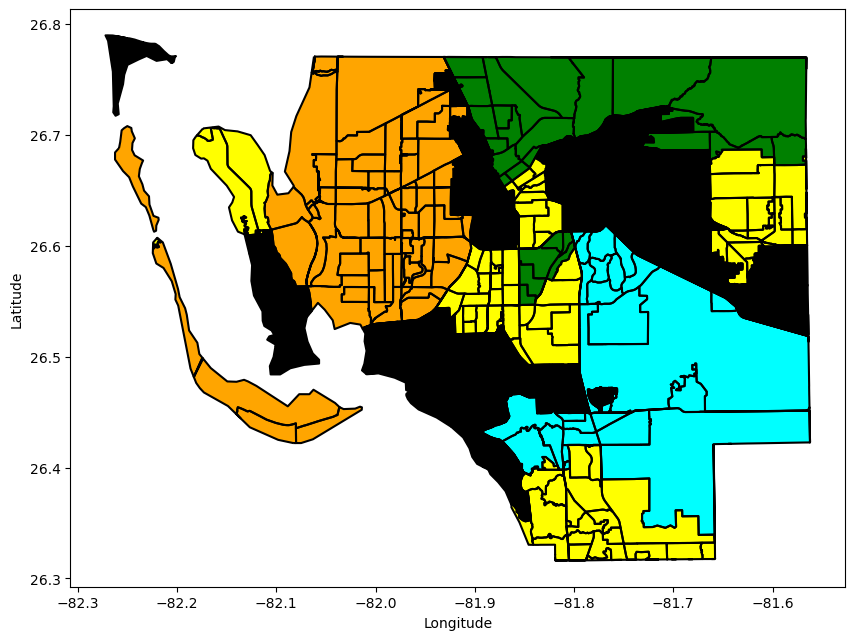

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

joint_tracts_zip.boundary.plot(ax=ax, edgecolor='black')
joint_tracts_zip.plot(ax=ax, color=damage_colors)

plt.show()

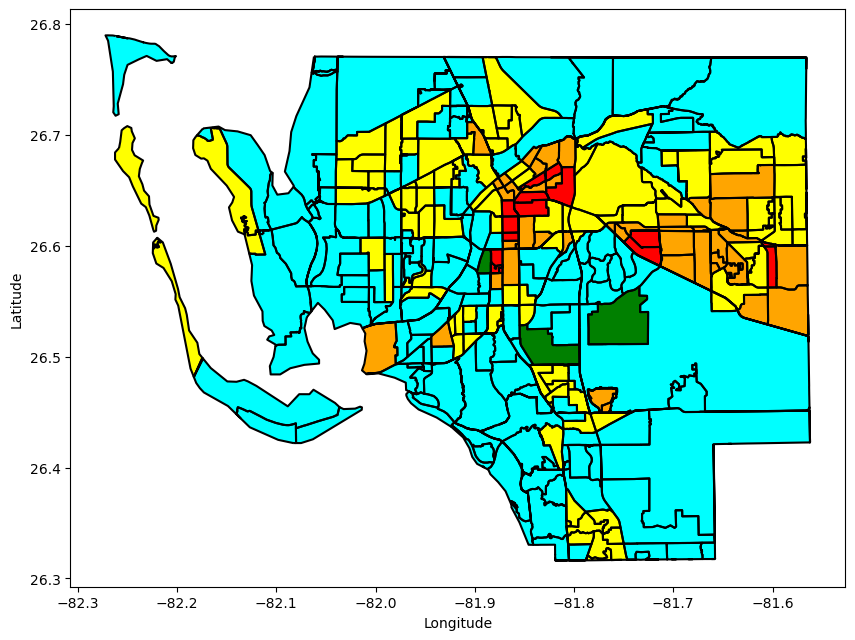

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

joint_tracts_zip.boundary.plot(ax=ax, edgecolor='black')
joint_tracts_zip.plot(ax=ax, color=sv_zone_colors)

plt.show()